In [98]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
import PIL
import cv2
import os
import pandas as pd
from PIL import Image
from keras.utils import plot_model
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

%matplotlib inline
%load_ext autoreload
%autoreload 2
print("Tensorflow version " + tf.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Tensorflow version 1.13.1


In [99]:
from keras.models import load_model
# load the model
model = load_model('../input/facenet-keras/facenet_keras.h5')

/opt/conda/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [100]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
__________________________________________________________________________________________________
Conv2d_2a_

In [101]:
print(model.inputs)
print(model.outputs)

[<tf.Tensor 'input_1_1:0' shape=(?, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm_1/cond/Merge:0' shape=(?, 128) dtype=float32>]


In [102]:
def triplet_loss(y_true, y_pred, alpha = 0.2):

    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    #Compute the (encoding) distance between the anchor and the positive, you will need to sum over axis=-1
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)),axis=-1)
    #Compute the (encoding) distance between the anchor and the negative, you will need to sum over axis=-1
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)),axis=-1)
    #subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist,neg_dist),alpha)
    #Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss,0.0))
    
    return loss

In [103]:
FRmodel = model

In [104]:
cascade_face = cv2.CascadeClassifier("../input/haarcascade-frontalface-defaultxml/haarcascade_frontalface_default.xml")

In [105]:
def img_to_encoding(image, model):
    target_size=(160, 160, 3)
    img = np.resize(image,target_size)
    img = np.around(np.array(img) / 255.0, decimals=12)
    x_train = np.expand_dims(img, axis=0)
    embedding = model.predict_on_batch(x_train)
    return embedding / np.linalg.norm(embedding, ord=2)

In [106]:
def image_processing_for_database(image_path, cascade_face):
    img = cv2.imread(image_path)
    face = cascade_face.detectMultiScale(img, 
        scaleFactor = 1.3,
        minNeighbors = 5,
        minSize = (30,30)
    )
    new_image = img
    for (x,y,w,h) in face:
        cv2.rectangle(img, (x,y), (x+w,y+h),(255,0,0),2)
        new_image = img[y:y+h, x:x+h]
    img = Image.fromarray(new_image)
    return img

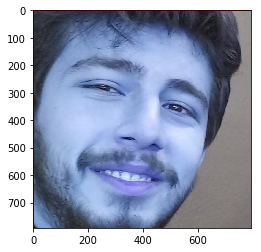

In [107]:
image = image_processing_for_database("../input/images-test/images/cihat.jpeg",cascade_face)
plt.imshow(image)

In [108]:
database = {}
image_list = os.listdir("../input/images-test/images/")
for image in image_list:
    if "test" not in image:
        name = image.split(".")[0]
        print(name)
        image_path = "../input/images-test/images/{}".format(image)
        image = image_processing_for_database(image_path,cascade_face)
        database[name] = img_to_encoding(image, FRmodel)

cihat
messi


In [109]:
database

{'cihat': array([[-1.14957308e-02, -8.88996571e-02, -6.55960739e-02,
         -8.12029243e-02,  9.01508629e-02, -8.61107856e-02,
          2.31496543e-02, -1.95544939e-02,  6.93013147e-02,
          1.97204314e-02,  3.11786309e-02, -6.98198900e-02,
          1.13936719e-02, -1.15323201e-01, -4.29034382e-02,
          7.75219277e-02,  8.75353292e-02, -1.06958643e-01,
          6.88779280e-02, -1.32998750e-01,  1.42285945e-02,
          4.62651476e-02, -6.16302900e-02,  2.48615649e-02,
          3.11109759e-02, -6.34530559e-02,  1.75193787e-01,
          7.45009035e-02, -1.82993859e-02,  2.67361570e-02,
         -1.03790060e-01,  5.16068600e-02,  4.90390733e-02,
         -1.38893332e-02,  1.27214447e-01, -9.95351821e-02,
          7.36656412e-02,  1.64383389e-02,  1.21964008e-01,
          1.40514299e-02,  5.62782474e-02,  2.86216047e-02,
         -1.12021402e-01, -3.21488008e-02, -1.23501673e-01,
         -1.22002333e-01, -5.44346694e-05, -5.65144010e-02,
          9.89193171e-02,  6.44

In [110]:
messi = tf.keras.preprocessing.image.load_img("../input/images-test/images/messi.jpg", target_size=(160, 160))

In [111]:
np.around(np.array(messi) / 255.0, decimals=12).shape

(160, 160, 3)

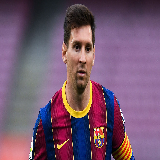

In [112]:
messi

In [113]:
cihat = tf.keras.preprocessing.image.load_img("../input/images-test/images/cihat.jpeg", target_size=(160, 160))

In [114]:
np.around(np.array(cihat) / 255.0, decimals=12).shape

(160, 160, 3)

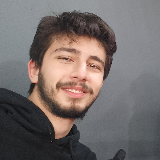

In [115]:
cihat

In [116]:
def verify(image_path, identity, database, model):
    #Compute the encoding for the image
    img = image_processing_for_database(image_path, cascade_face)
    encoding = img_to_encoding(img, model)
    plt_img = np.array(Image.open(image_path))
    plt.imshow(plt_img)
    
    #Compute distance with identity's image
    dist = np.linalg.norm(encoding - database[identity])
    
    #Open the door if dist < 0.7, else don't open
    if dist<0.7:
        print("It's " + str(identity) + ", welcome home!")
        door_open = True
    else:
        print("It's not " + str(identity) + ", please go away")
        door_open = False
      
    return dist, door_open

It's cihat, welcome home!
( 0.2118917 , True )


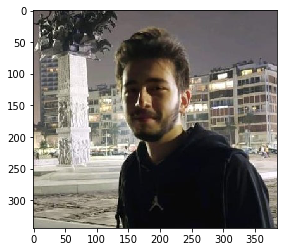

In [117]:
distance, door_open_flag = verify("../input/images-test/images/cihat_test.jpg", "cihat", database, FRmodel)
print("(", distance, ",", door_open_flag, ")")

It's messi, welcome home!


(0.6091957, True)

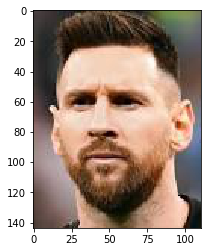

In [118]:
verify("../input/images-test/images/messi_test.jpg", "messi", database, FRmodel)

It's not cihat, please go away


(0.7080088, False)

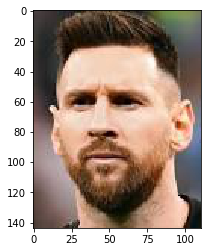

In [119]:
verify("../input/images-test/images/messi_test.jpg", "cihat", database, FRmodel)

In [120]:
def who_is_it(image_path, database, model):
    #Compute the target "encoding" for the image.
    img = image_processing_for_database(image_path, cascade_face)
    encoding = img_to_encoding(img, model)
    plt_img = np.array(Image.open(image_path))
    plt.imshow(plt_img)
    
    
    ##Find the closest encoding 
    min_dist = 100
    for (name, db_enc) in database.items():
        dist = np.linalg.norm(encoding - db_enc)
        if dist < min_dist:
            min_dist = dist
            identity = name 
    
    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    return min_dist, identity

it's cihat, the distance is 0.2118917


(0.2118917, 'cihat')

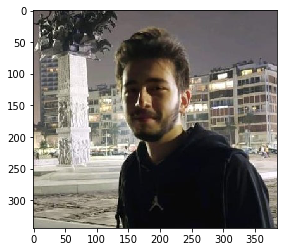

In [121]:
who_is_it("../input/images-test/images/cihat_test.jpg", database, FRmodel)

it's messi, the distance is 0.6091957


(0.6091957, 'messi')

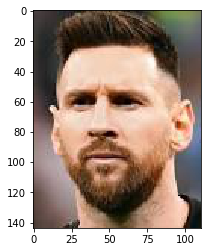

In [122]:
who_is_it("../input/images-test/images/messi_test.jpg", database, FRmodel)